## Decision Trees

Decision trees are widely used models for classification and regression tasks.  Eseentially, they learn a hierarchy of if/else questions, leading to a decision.

These questions are similar to the questions you might ask in a game of *20 Questions*:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

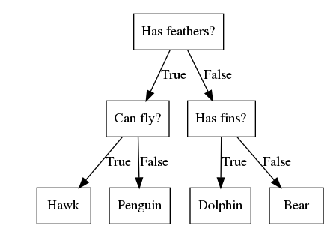

In [2]:
mglearn.plots.plot_animal_tree()

In this illustration, each node in the tree either represents a question or a leaf that contains the answer.  The edges connect the answers to a question with the next question you would ask.

In machine learning parlance, we built a model to distinguish between 4 classes of animals (*hawks, penguins, dolphins, and bears*) using 3 features (*'has feathers', 'can fly', and 'has fins'*).

### Building Decision Trees

We'll go through the process of building a decision tree for a 2D classification dataset, *two-moons*, that consists of 2 half-moon shapes, with each class consisting of 75 data points.

Learning a decision tree means learning the sequence of if/else questions that gets us to the true answer most quickly.  In machine learning settings, these questions are called *tests*.  Usually data does not come in the form of yes/no questions like in the animal tree, but instead represented as continuous features.  The tests that are used on continuous data are of the form *Is Feature i larger than value a?*

To build a tree, the algorithm searches over all possible tests and finds the one that is most informative about the target variable.  

For the first test, splitting the dataset horizontally at x[1]=0.0596 yields the most information.  The root node represents the entire data set, corresponding to 50 points belonging to class 0 and 50 points belonging to class 1.  

If the test (*X[1] <= 0.0596*) is true, a point is assigned to the left node, which contains 2 points belonging to class 0 and 32 points belonging to class 1.

If the test is false, a point is assigned to the right node, which contains 48 points belonging to class 0 and 18 points belonging to class 1.  

Even though the first split did a good job of separating the two classes, the bottom region still contains points belonging to class 0 and the top region still contains points belonging to class 1.

![Decision Tree (Depth=1)](img/d1decisiontree.png)

We can build a more accurate model by repeating the process of looking for the best test in both regions.

![Decision Tree (Depth=2)](img/d2decisiontree.png)

The recursive process yields a binary tree of decisions, with each node containing a test.  Alternatively, we can think of each test as splitting the part of the data that is currently being considered along one axis.  

This yields a view of the algorithm as building a hierarchical position.  As each test concerns only a single feature, the regions in the resulting partition always have axis-parallel boundaries.

The recursive partitioning of the data is repeated until each region in the partition only contains a single target value.  A leaf of the tree that contains data points that all share the same target value is called *pure*.

![Decision Tree (Depth=Final)](img/d9decisiontree.png)

A prediction on a new data point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majority target in that region.  The region can be found by traversing the tree and going left or right depending on whether the test is fulfilled or not.

It is also possible to use trees for regression tasks using exactly the same technique.  To make a prediction, we traverse the tree based on the tests in each node and find the leaf the new data point falls into.  The output for the data point is the mean target of the training points in this leaf.

### Controlling Complexity of Decision Trees

Typically, building a tree until all leaves are pure leads to a very complex and highly overfit model.  The presence of pure leaves means the tree is 100% accurate on the training set.  

There are two common strategies to prevent overfitting:
- *Pre-pruning* = stopping the creation of the tree early
- *Post-pruning* = removing or collapsing nodes that contain little information

Possible criteria for pre-pruning include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting it.

Decision trees in *scikit-learn* are implemented in the *DecisionTreeRegressor* and *DecisionTreeClassifier* classes.  *scikit-learn* only implements pre-pruning, not post-pruning.

Here, we'll look at the effect of pre-pruning in more detail on the Breast Cancer dataset.  We'll also fix the *random_state* in the tree, used for tie-breaking internally.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


As expected, the accuracy on the training set is 100%, because the leaves are pure.  Now, we'll try applying pre-pruning to the tree by setting *max_depth=4*.

In [9]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


By pre-pruning the tree, we get a lower accuracy on the training set, but a better accuracy on the test set.

### Analyzing Decision Trees

We can visualize the tree using the *export_graphviz* function from the *tree* module.  This writes a file to the *.dot* file format, which is a text file format for storing graphs.

In [10]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

Now, we can read this file and visualize it using the *graphviz* module.

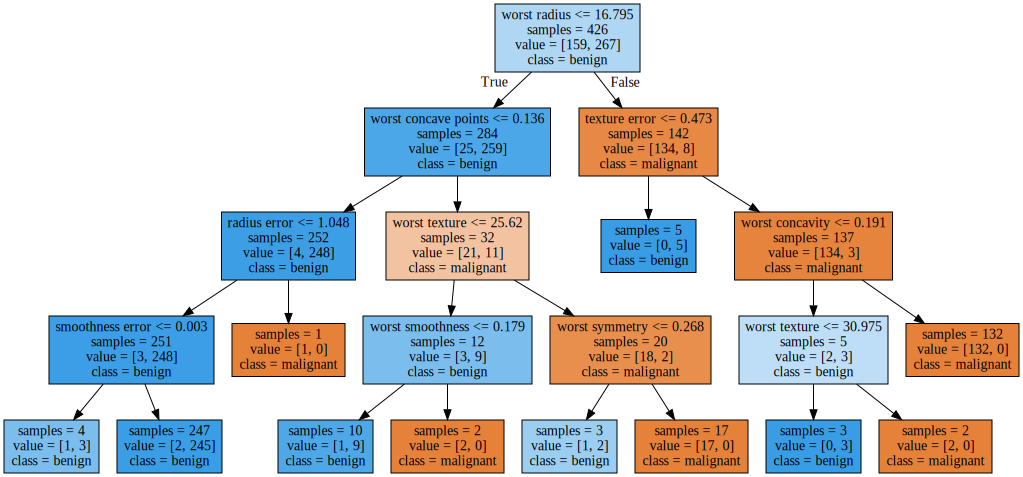

In [11]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

The visualization of the tree provides a great in-depth view of how the algorithm makes predictions.  This makes it a good example of a machine learning algorithm that is easily explained to non-experts.  